In [3]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from sklearn.base import BaseEstimator, RegressorMixin
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor, StackingRegressor
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# ==================== Data Preprocessing ====================
df = pd.read_csv("cleaned_car_data.csv")
df = df[df['price'] <= 250000]
X = df.drop(columns=['price'])
y = df['price']
y_log = np.log1p(y)

categorical_cols = X.select_dtypes(include=['object']).columns.tolist()
numerical_cols = X.select_dtypes(include=['int64', 'float64']).columns.tolist()

preprocessor = ColumnTransformer([
    ('num', StandardScaler(), numerical_cols),
    ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_cols)
])

X_processed = preprocessor.fit_transform(X)

y_log = y_log.values.reshape(-1, 1)

target_scaler = StandardScaler()
y_scaled = target_scaler.fit_transform(y_log)

X_train, X_test, y_train, y_test = train_test_split(X_processed, y_scaled, test_size=0.2, random_state=1)

# ==================== PyTorch Regressor Wrapper ====================
class CarPriceMLP(nn.Module):
    def __init__(self, input_dim):
        super().__init__()
        self.model = nn.Sequential(
            nn.Linear(input_dim, 128),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(64, 32),
            nn.ReLU(),
            nn.Linear(32, 1)
        )

    def forward(self, x):
        return self.model(x)

class TorchRegressor(BaseEstimator, RegressorMixin):
    _estimator_type = "regressor"

    def __init__(self, input_dim, lr=0.001, epochs=100, batch_size=64, verbose=False):
        self.input_dim = input_dim
        self.lr = lr
        self.epochs = epochs
        self.batch_size = batch_size
        self.verbose = verbose

        self.model = CarPriceMLP(self.input_dim)  # Init here
        self.criterion = nn.MSELoss()
        self.optimizer = optim.Adam(self.model.parameters(), lr=self.lr)

    def fit(self, X, y):
        self.model.train()
        X_tensor = torch.tensor(X.toarray() if hasattr(X, 'toarray') else X, dtype=torch.float32)
        y_tensor = torch.tensor(y, dtype=torch.float32)

        dataset = TensorDataset(X_tensor, y_tensor)
        loader = DataLoader(dataset, batch_size=self.batch_size, shuffle=True)

        for epoch in range(self.epochs):
            for X_batch, y_batch in loader:
                self.optimizer.zero_grad()
                outputs = self.model(X_batch)
                loss = self.criterion(outputs, y_batch)
                loss.backward()
                self.optimizer.step()
            if self.verbose and (epoch+1) % 20 == 0:
                print(f"Epoch {epoch+1}/{self.epochs}, Loss: {loss.item():.4f}")
        return self

    def predict(self, X):
        self.model.eval()
        X_tensor = torch.tensor(X.toarray() if hasattr(X, 'toarray') else X, dtype=torch.float32)
        with torch.no_grad():
            preds = self.model(X_tensor).numpy()
        return preds



# ==================== Stack Models ====================
rf_model = RandomForestRegressor(
    n_estimators=200,
    max_depth=15,
    min_samples_split=5,
    min_samples_leaf=2,
    random_state=0,
    n_jobs=-1
)

torch_model = TorchRegressor(input_dim=X_train.shape[1], epochs=100)

stacked_model = StackingRegressor(
    estimators=[
        ('rf', rf_model),
        ('mlp', torch_model)
    ],
    final_estimator=LinearRegression(),
    passthrough=True
)

# ==================== Train and Evaluate ====================
stacked_model.fit(X_train, y_train)

y_pred_scaled = stacked_model.predict(X_test)
y_pred = np.expm1(target_scaler.inverse_transform(y_pred_scaled.reshape(-1, 1)))
y_true = np.expm1(target_scaler.inverse_transform(y_test.reshape(-1, 1)))

print(f"R² Score: {r2_score(y_true, y_pred):.4f}")
print(f"RMSE: {np.sqrt(mean_squared_error(y_true, y_pred)):.2f}")
print(f"MAE: {mean_absolute_error(y_true, y_pred):.2f}")


/Users/amanshaik/anaconda/lib/python3.9/site-packages/sklearn/ensemble/_stacking.py:865: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/amanshaik/anaconda/lib/python3.9/site-packages/torch/nn/modules/loss.py:610: UserWarning: Using a target size (torch.Size([64])) that is different to the input size (torch.Size([64, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/amanshaik/anaconda/lib/python3.9/site-packages/torch/nn/modules/loss.py:610: UserWarning: Using a target size (torch.Size([32])) that is different to the input size (torch.Size([32, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Use

R² Score: 0.6892
RMSE: 21058.88
MAE: 9602.60


In [2]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from sklearn.base import BaseEstimator, RegressorMixin
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor, StackingRegressor, GradientBoostingRegressor
from sklearn.preprocessing import OneHotEncoder, RobustScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# ==================== Data Preprocessing ====================
df = pd.read_csv("cleaned_car_data.csv")
df = df[df['price'] <= 250000]
X = df.drop(columns=['price'])
y = df['price']
y_log = np.log1p(y)

categorical_cols = X.select_dtypes(include=['object']).columns.tolist()
numerical_cols = X.select_dtypes(include=['int64', 'float64']).columns.tolist()

preprocessor = ColumnTransformer([
    ('num', RobustScaler(), numerical_cols),  # Changed to RobustScaler
    ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_cols)
])

X_processed = preprocessor.fit_transform(X)

y_log = y_log.values.reshape(-1, 1)
target_scaler = RobustScaler()
y_scaled = target_scaler.fit_transform(y_log)

X_train, X_test, y_train, y_test = train_test_split(X_processed, y_scaled, test_size=0.2, random_state=1)

# ==================== PyTorch Regressor Wrapper ====================
class CarPriceMLP(nn.Module):
    def __init__(self, input_dim):
        super().__init__()
        self.model = nn.Sequential(
            nn.Linear(input_dim, 256),
            nn.BatchNorm1d(256),
            nn.LeakyReLU(),
            nn.Dropout(0.3),
            nn.Linear(256, 128),
            nn.BatchNorm1d(128),
            nn.LeakyReLU(),
            nn.Dropout(0.2),
            nn.Linear(128, 64),
            nn.LeakyReLU(),
            nn.Linear(64, 1)
        )

    def forward(self, x):
        return self.model(x)

class TorchRegressor(BaseEstimator, RegressorMixin):
    _estimator_type = "regressor"

    def __init__(self, input_dim, lr=0.001, epochs=150, batch_size=64, verbose=False):
        self.input_dim = input_dim
        self.lr = lr
        self.epochs = epochs
        self.batch_size = batch_size
        self.verbose = verbose
        self.model = CarPriceMLP(self.input_dim)
        self.criterion = nn.MSELoss()
        self.optimizer = optim.Adam(self.model.parameters(), lr=self.lr, weight_decay=1e-5)

    def fit(self, X, y):
        self.model.train()
        X_tensor = torch.tensor(X.toarray() if hasattr(X, 'toarray') else X, dtype=torch.float32)
        y_tensor = torch.tensor(y, dtype=torch.float32)

        dataset = TensorDataset(X_tensor, y_tensor)
        loader = DataLoader(dataset, batch_size=self.batch_size, shuffle=True)

        best_loss = np.inf
        patience = 10
        trigger_times = 0

        for epoch in range(self.epochs):
            epoch_loss = 0
            for X_batch, y_batch in loader:
                self.optimizer.zero_grad()
                outputs = self.model(X_batch)
                loss = self.criterion(outputs, y_batch)
                loss.backward()
                self.optimizer.step()
                epoch_loss += loss.item()

            epoch_loss /= len(loader)
            if self.verbose:
                print(f"Epoch {epoch+1}, Loss: {epoch_loss:.4f}")

            if epoch_loss < best_loss:
                best_loss = epoch_loss
                trigger_times = 0
            else:
                trigger_times += 1
                if trigger_times >= patience:
                    if self.verbose:
                        print("Early stopping triggered.")
                    break
        return self

    def predict(self, X):
        self.model.eval()
        X_tensor = torch.tensor(X.toarray() if hasattr(X, 'toarray') else X, dtype=torch.float32)
        with torch.no_grad():
            preds = self.model(X_tensor).numpy()
        return preds

# ==================== Stack Models ====================
rf_model = RandomForestRegressor(
    n_estimators=200,
    max_depth=15,
    min_samples_split=5,
    min_samples_leaf=2,
    random_state=0,
    n_jobs=-1
)

torch_model = TorchRegressor(input_dim=X_train.shape[1], epochs=150, verbose=True)

stacked_model = StackingRegressor(
    estimators=[
        ('rf', rf_model),
        ('mlp', torch_model)
    ],
    final_estimator=GradientBoostingRegressor(n_estimators=100, learning_rate=0.05),
    passthrough=True
)

# ==================== Train and Evaluate ====================
stacked_model.fit(X_train, y_train)

y_pred_scaled = stacked_model.predict(X_test)
y_pred = np.expm1(target_scaler.inverse_transform(y_pred_scaled.reshape(-1, 1)))
y_true = np.expm1(target_scaler.inverse_transform(y_test.reshape(-1, 1)))

print(f"R² Score: {r2_score(y_true, y_pred):.4f}")
print(f"RMSE: {np.sqrt(mean_squared_error(y_true, y_pred)):.2f}")
print(f"MAE: {mean_absolute_error(y_true, y_pred):.2f}")


/Users/amanshaik/anaconda/lib/python3.9/site-packages/sklearn/ensemble/_stacking.py:865: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/amanshaik/anaconda/lib/python3.9/site-packages/torch/nn/modules/loss.py:610: UserWarning: Using a target size (torch.Size([64])) that is different to the input size (torch.Size([64, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/amanshaik/anaconda/lib/python3.9/site-packages/torch/nn/modules/loss.py:610: UserWarning: Using a target size (torch.Size([32])) that is different to the input size (torch.Size([32, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch 1, Loss: 0.5704
Epoch 2, Loss: 0.5654
Epoch 3, Loss: 0.5614
Epoch 4, Loss: 0.5611
Epoch 5, Loss: 0.5624
Epoch 6, Loss: 0.5631
Epoch 7, Loss: 0.5605
Epoch 8, Loss: 0.5612
Epoch 9, Loss: 0.5599
Epoch 10, Loss: 0.5607
Epoch 11, Loss: 0.5629
Epoch 12, Loss: 0.5635
Epoch 13, Loss: 0.5614
Epoch 14, Loss: 0.5619
Epoch 15, Loss: 0.5616
Epoch 16, Loss: 0.5608
Epoch 17, Loss: 0.5590
Epoch 18, Loss: 0.5619
Epoch 19, Loss: 0.5634
Epoch 20, Loss: 0.5613
Epoch 21, Loss: 0.5624
Epoch 22, Loss: 0.5583
Epoch 23, Loss: 0.5589
Epoch 24, Loss: 0.5600
Epoch 25, Loss: 0.5576
Epoch 26, Loss: 0.5606
Epoch 27, Loss: 0.5635
Epoch 28, Loss: 0.5598
Epoch 29, Loss: 0.5594
Epoch 30, Loss: 0.5625
Epoch 31, Loss: 0.5590
Epoch 32, Loss: 0.5580
Epoch 33, Loss: 0.5618
Epoch 34, Loss: 0.5598
Epoch 35, Loss: 0.5615
Early stopping triggered.


/Users/amanshaik/anaconda/lib/python3.9/site-packages/torch/nn/modules/loss.py:610: UserWarning: Using a target size (torch.Size([64])) that is different to the input size (torch.Size([64, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/amanshaik/anaconda/lib/python3.9/site-packages/torch/nn/modules/loss.py:610: UserWarning: Using a target size (torch.Size([38])) that is different to the input size (torch.Size([38, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch 1, Loss: 0.5768
Epoch 2, Loss: 0.5706
Epoch 3, Loss: 0.5662
Epoch 4, Loss: 0.5717
Epoch 5, Loss: 0.5665
Epoch 6, Loss: 0.5661
Epoch 7, Loss: 0.5659
Epoch 8, Loss: 0.5643
Epoch 9, Loss: 0.5672
Epoch 10, Loss: 0.5643
Epoch 11, Loss: 0.5661
Epoch 12, Loss: 0.5677
Epoch 13, Loss: 0.5653
Epoch 14, Loss: 0.5649
Epoch 15, Loss: 0.5666
Epoch 16, Loss: 0.5683
Epoch 17, Loss: 0.5659
Epoch 18, Loss: 0.5675
Epoch 19, Loss: 0.5647
Epoch 20, Loss: 0.5663
Early stopping triggered.
Epoch 1, Loss: 0.5766
Epoch 2, Loss: 0.5653
Epoch 3, Loss: 0.5627
Epoch 4, Loss: 0.5626
Epoch 5, Loss: 0.5651
Epoch 6, Loss: 0.5616
Epoch 7, Loss: 0.5620
Epoch 8, Loss: 0.5617
Epoch 9, Loss: 0.5594
Epoch 10, Loss: 0.5598
Epoch 11, Loss: 0.5614
Epoch 12, Loss: 0.5598
Epoch 13, Loss: 0.5602
Epoch 14, Loss: 0.5633
Epoch 15, Loss: 0.5619
Epoch 16, Loss: 0.5601
Epoch 17, Loss: 0.5600
Epoch 18, Loss: 0.5609
Epoch 19, Loss: 0.5577
Epoch 20, Loss: 0.5596
Epoch 21, Loss: 0.5600
Epoch 22, Loss: 0.5603
Epoch 23, Loss: 0.5576
Epo

/Users/amanshaik/anaconda/lib/python3.9/site-packages/torch/nn/modules/loss.py:610: UserWarning: Using a target size (torch.Size([39])) that is different to the input size (torch.Size([39, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch 2, Loss: 0.5675
Epoch 3, Loss: 0.5647
Epoch 4, Loss: 0.5641
Epoch 5, Loss: 0.5625
Epoch 6, Loss: 0.5639
Epoch 7, Loss: 0.5613
Epoch 8, Loss: 0.5629
Epoch 9, Loss: 0.5620
Epoch 10, Loss: 0.5624
Epoch 11, Loss: 0.5615
Epoch 12, Loss: 0.5628
Epoch 13, Loss: 0.5609
Epoch 14, Loss: 0.5641
Epoch 15, Loss: 0.5597
Epoch 16, Loss: 0.5609
Epoch 17, Loss: 0.5620
Epoch 18, Loss: 0.5623
Epoch 19, Loss: 0.5620
Epoch 20, Loss: 0.5628
Epoch 21, Loss: 0.5627
Epoch 22, Loss: 0.5608
Epoch 23, Loss: 0.5609
Epoch 24, Loss: 0.5594
Epoch 25, Loss: 0.5629
Epoch 26, Loss: 0.5603
Epoch 27, Loss: 0.5595
Epoch 28, Loss: 0.5624
Epoch 29, Loss: 0.5617
Epoch 30, Loss: 0.5627
Epoch 31, Loss: 0.5627
Epoch 32, Loss: 0.5608
Epoch 33, Loss: 0.5625
Epoch 34, Loss: 0.5630
Early stopping triggered.
Epoch 1, Loss: 0.5688
Epoch 2, Loss: 0.5575
Epoch 3, Loss: 0.5557
Epoch 4, Loss: 0.5583
Epoch 5, Loss: 0.5581
Epoch 6, Loss: 0.5530
Epoch 7, Loss: 0.5528
Epoch 8, Loss: 0.5539
Epoch 9, Loss: 0.5544
Epoch 10, Loss: 0.5556
Ep

Training models...

Evaluation Results:

Random Forest Performance:
Root Mean Squared Error: 7292.93
Mean Absolute Error: 4492.45
R² Score: 0.9470


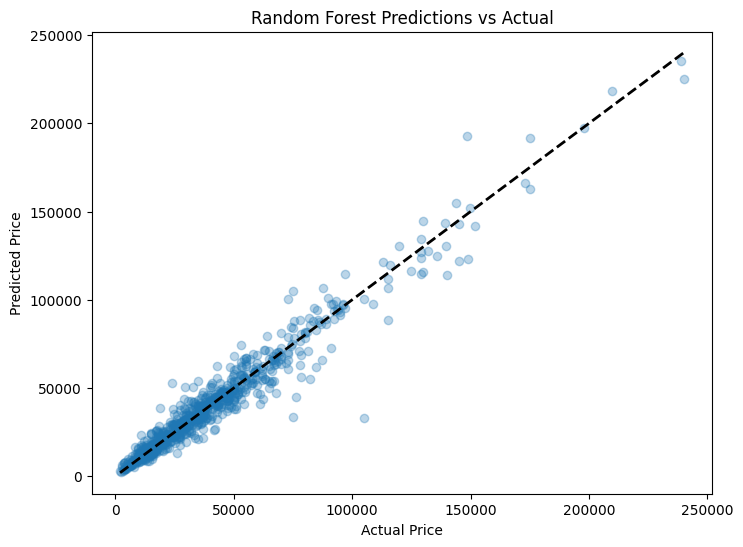


Neural Network Performance:
Root Mean Squared Error: 11797.70
Mean Absolute Error: 6508.32
R² Score: 0.8612


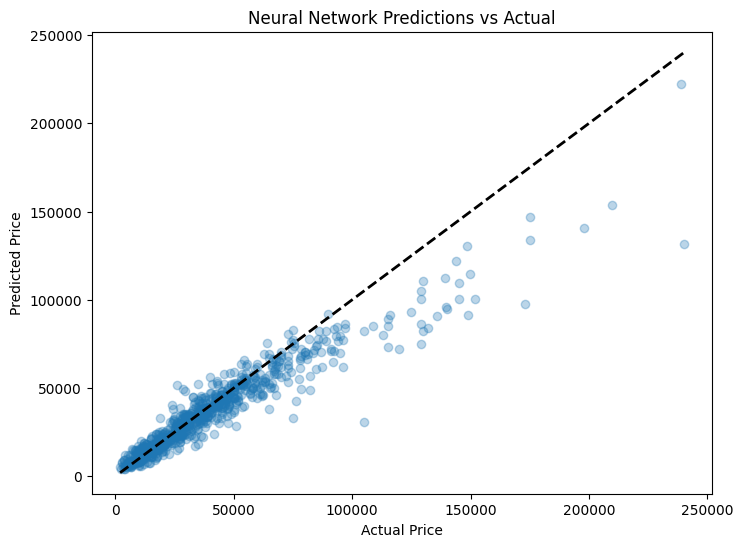


Stacked Ensemble Performance:
Root Mean Squared Error: 7546.07
Mean Absolute Error: 4698.25
R² Score: 0.9432


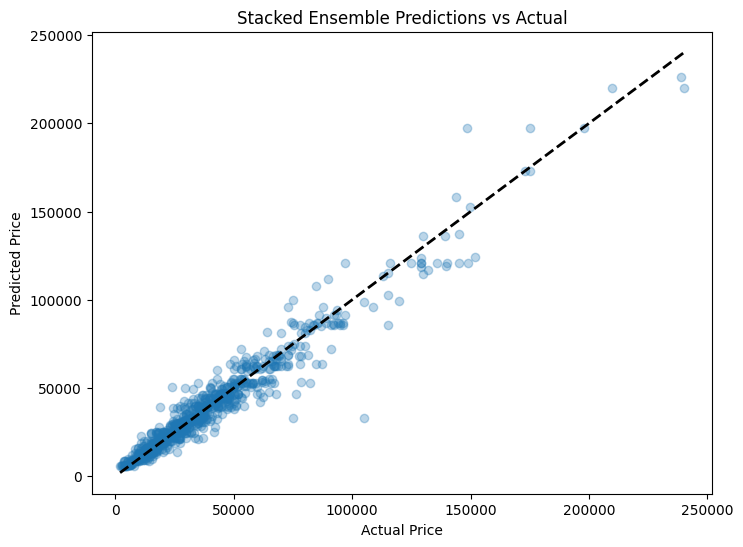


Model Comparison:
              Model          RMSE          MAE        R²
0     Random Forest   7292.927187  4492.447617  0.946979
1    Neural Network  11797.698885  6508.321579  0.861249
2  Stacked Ensemble   7546.074026  4698.246602  0.943235


In [4]:
import pandas as pd
import numpy as np
import re
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader
from sklearn.model_selection import train_test_split, KFold
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, StackingRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.base import BaseEstimator, RegressorMixin
import matplotlib.pyplot as plt

# ==================== Data Loading and Preprocessing ====================
def load_and_preprocess_data():
    df = pd.read_csv('cleaned_car_data.csv')
    df = df[df['price'] < 250000]
    df['clean_title'] = df['clean_title'].map({'Yes': 1, 'No': 0}).astype(int)

    df['brand_encoded'] = df.groupby('brand')['price'].transform('mean')
    df['model_encoded'] = df.groupby('model')['price'].transform('mean')
    df['engine_encoded'] = df.groupby('engine')['price'].transform('mean')
    df['transmission_encoded'] = df.groupby('transmission')['price'].transform('mean')

    def extract_hp(engine_str):
        match = re.search(r'(\d+(?:\.\d+)?)\s*hp', str(engine_str).lower())
        if match:
            return float(match.group(1))
        return np.nan

    df['HP'] = df['engine'].apply(extract_hp)
    df['HP'].fillna(df['HP'].median(), inplace=True)
    df['mileage_binned'] = pd.qcut(df['mileage'], q=10, labels=False)

    numerical = ['model_year', 'mileage_binned', 'HP']
    binary = ['clean_title']
    encoded = ['brand_encoded', 'model_encoded', 'engine_encoded', 'transmission_encoded']
    categorical = ['fuel_type', 'ext_col', 'int_col', 'accident']
    df_cat = pd.get_dummies(df[categorical], drop_first=True)

    X = pd.concat([df[numerical + binary + encoded], df_cat], axis=1)
    y = df['price']
    return X, y

# ==================== Neural Network ====================
class CarPriceMLP(nn.Module):
    def __init__(self, input_dim):
        super().__init__()
        self.model = nn.Sequential(
            nn.Linear(input_dim, 128),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(64, 32),
            nn.ReLU(),
            nn.Linear(32, 1)
        )

    def forward(self, x):
        return self.model(x)

# ==================== Torch Regressor Wrapper ====================
class TorchRegressor(BaseEstimator, RegressorMixin):
    def __init__(self, input_dim=None, epochs=300, batch_size=64, lr=0.001):
        self.input_dim = input_dim
        self.epochs = epochs
        self.batch_size = batch_size
        self.lr = lr
        self.scaler = StandardScaler()
        self.target_scaler = StandardScaler()
        self.model = None  # Delay model init

    def fit(self, X, y):
        X_np = np.array(X)
        y_np = np.array(y).reshape(-1, 1)

        X_scaled = self.scaler.fit_transform(X_np)
        y_scaled = self.target_scaler.fit_transform(np.log1p(y_np))

        X_tensor = torch.tensor(X_scaled, dtype=torch.float32)
        y_tensor = torch.tensor(y_scaled, dtype=torch.float32)
        dataset = TensorDataset(X_tensor, y_tensor)
        loader = DataLoader(dataset, batch_size=self.batch_size, shuffle=True)

        if self.model is None:
            self.input_dim = X_np.shape[1]
            self.model = CarPriceMLP(self.input_dim)

        criterion = nn.MSELoss()
        optimizer = optim.Adam(self.model.parameters(), lr=self.lr)
        scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=50, gamma=0.5)

        self.model.train()
        for epoch in range(self.epochs):
            for batch_X, batch_y in loader:
                optimizer.zero_grad()
                outputs = self.model(batch_X)
                loss = criterion(outputs, batch_y)
                loss.backward()
                optimizer.step()
            scheduler.step()
        return self

    def predict(self, X):
        X_np = np.array(X)
        X_scaled = self.scaler.transform(X_np)
        X_tensor = torch.tensor(X_scaled, dtype=torch.float32)

        self.model.eval()
        with torch.no_grad():
            y_pred = self.model(X_tensor).numpy()
        return np.expm1(self.target_scaler.inverse_transform(y_pred)).flatten()

# ==================== Evaluation ====================
def evaluate_model(name, model, X, y):
    y_pred = model.predict(X)
    rmse = np.sqrt(mean_squared_error(y, y_pred))
    mae = mean_absolute_error(y, y_pred)
    r2 = r2_score(y, y_pred)

    print(f"\n{name} Performance:")
    print(f"Root Mean Squared Error: {rmse:.2f}")
    print(f"Mean Absolute Error: {mae:.2f}")
    print(f"R² Score: {r2:.4f}")

    plt.figure(figsize=(8, 6))
    plt.scatter(y, y_pred, alpha=0.3)
    plt.plot([y.min(), y.max()], [y.min(), y.max()], 'k--', lw=2)
    plt.xlabel('Actual Price')
    plt.ylabel('Predicted Price')
    plt.title(f'{name} Predictions vs Actual')
    plt.show()

    return rmse, mae, r2

# ==================== Main ====================
if __name__ == "__main__":
    X, y = load_and_preprocess_data()
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    rf_model = RandomForestRegressor(
        n_estimators=200,
        max_depth=15,
        min_samples_split=5,
        min_samples_leaf=2,
        random_state=0,
        n_jobs=-1
    )

    nn_model = TorchRegressor(epochs=300, batch_size=64, lr=0.001)  # input_dim will be inferred in fit()

    stacking_regressor = StackingRegressor(
        estimators=[
            ('random_forest', rf_model),
            ('neural_net', nn_model)
        ],
        final_estimator=GradientBoostingRegressor(
            n_estimators=100,
            learning_rate=0.05,
            max_depth=3,
            random_state=42
        ),
        cv=KFold(n_splits=5, shuffle=True, random_state=42),
        n_jobs=-1
    )

    print("Training models...")
    rf_model.fit(X_train, y_train)
    nn_model.fit(X_train, y_train)
    stacking_regressor.fit(X_train, y_train)

    print("\nEvaluation Results:")
    rf_metrics = evaluate_model("Random Forest", rf_model, X_test, y_test)
    nn_metrics = evaluate_model("Neural Network", nn_model, X_test, y_test)
    stack_metrics = evaluate_model("Stacked Ensemble", stacking_regressor, X_test, y_test)

    results = pd.DataFrame({
        'Model': ['Random Forest', 'Neural Network', 'Stacked Ensemble'],
        'RMSE': [rf_metrics[0], nn_metrics[0], stack_metrics[0]],
        'MAE': [rf_metrics[1], nn_metrics[1], stack_metrics[1]],
        'R²': [rf_metrics[2], nn_metrics[2], stack_metrics[2]]
    })
    print("\nModel Comparison:")
    print(results)

    predictions = pd.DataFrame({
        'Actual': y_test,
        'RF_Pred': rf_model.predict(X_test),
        'NN_Pred': nn_model.predict(X_test),
        'Stacked_Pred': stacking_regressor.predict(X_test)
    })
    predictions.to_csv('model_predictions.csv', index=False)
